In [1]:
import re

from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class TopicAnalysis:
    def __init__(self):
        self.lda_model = None
        self.vectorizer = None

    @staticmethod
    def preprocess_text(text):
        stop_words = set(stopwords.words('english'))
        ps = PorterStemmer()
        
        text = re.sub(r'[,.!?{}%\[\]#()]', '', text)
        text = re.sub(r'\n+', ' ', text)

        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        
        tokens = word_tokenize(text)  # Tokenization
        tokens = [token for token in tokens if
                  token.isalpha() and token not in stop_words and len(token) > 1]  # Remove non-alphanumeric and stop words
    
        stemmed_tokens = [ps.stem(token) for token in tokens]
        
        return stemmed_tokens

    def train_model(self, training_column, num_topics, save_visual=False):
        all_texts = training_column.apply(TopicAnalysis.preprocess_text)
        
        self.dictionary = corpora.Dictionary(all_texts)
        corpus = [self.dictionary.doc2bow(text) for text in all_texts]

        self.lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=self.dictionary, passes=10, random_state=42)
    
    def model_text(self, document):
        text = TopicAnalysis.preprocess_text(document)
        corpus = self.dictionary.doc2bow(text)
        values = self.lda_model.get_document_topics(corpus)

        return_topics = [0.0 for key in range(5)]
        for value in values:
            return_topics[value[0]] = value[1]
        return return_topics



This class does some basic pre-processing and lemmatizes the words. Then it performs topic analysis on the resulting corpus. I've set the number of topics to 5 since we have 5 given categories.

In [2]:
folder = 'C:\\Users\\natha\\Documents\\PythonNotebooks\\data\\News\\'
df_train = pd.read_csv(folder + 'BBC News Train.csv')
df_test = pd.read_csv(folder + 'BBC News Test.csv')

In [3]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


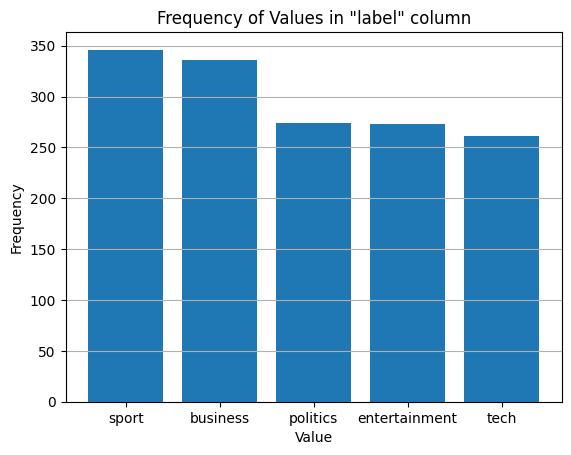

In [5]:
value_counts = df_train['Category'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.title('Frequency of Values in "label" column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(value_counts.index)  # Setting x-axis ticks to the unique values in 'target'
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()

In [6]:
model = TopicAnalysis()
model.train_model(pd.concat([df_test['Text'], df_train['Text']]), num_topics=5)

In [7]:
def get_topic_number(x):
    result = model.model_text(x)
    return np.argmax(result)
    
df_train['predictions'] = df_train['Text'].apply(get_topic_number)

In [8]:
df_train.head()

,ArticleId,Text,Category,predictions
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1
1,154,german business confidence slides german busin...,business,2
2,1101,bbc poll indicates economic gloom citizens in ...,business,1
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,1


Now I have categorized everything, but I need to determine what the best matching of predicted category and category name is. I'll iterate through the different ways we can match the categories to the int predictions, calculate the resulting accuracy, and use the highest accuracy mapping. Then use that to label the test data.

In [9]:
import itertools
from sklearn.metrics import accuracy_score

categories = df_train['Category'].unique().tolist()
best_perm = None
best_accuracy = -1

for perm in itertools.permutations(categories):
    prediction = df_train['predictions'].apply(lambda x: perm[x])

    accuracy = accuracy_score(df_train['Category'], prediction)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_perm = perm
print(f'Categories: {best_perm}')
print(f'With an accuracy of {round(best_accuracy, 4)}')

Categories: ('business', 'politics', 'entertainment', 'sport', 'tech')
With an accuracy of 0.6309


Originally I trained only on the train data, but realized I should be clustering on everything. Still underwhelming accuracy but much better than the low 50s I started out with.

In [10]:
def apply_category(x, permutation):
    result = model.model_text(x)
    return permutation[np.argmax(result)]
df_test['Category'] = df_test['Text'].apply(lambda x: apply_category(x, best_perm))

In [11]:
df_test[['ArticleId', 'Category']].to_csv('data/News/predictions.csv', index=False)